In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from os.path import join
import datetime

from models.base_line import BasicModel
from training.trainer_base import Trainer
from data.transforms import ResizeTransform
from modules.cross_validation import MyKFoldCV
from modules.dataset_handling import DatasetHandler
from modules.logging import MyLogger
from utils.metrics import compute_confusion_matrices, compute_accuracy, compute_f1score
from utils.visulisation import visualize_confusion_matrices


torch.manual_seed(42)


in_size = 128
out_size = 2

project_path = "/home/gatemrou/uds/Eye_Tracking/"
assert(os.path.exists(project_path))

In [2]:
data_type = 'scanpath'       # scanpath or heatmap
scanpath_type = 'b'       # a, b or c
model_type = 'base'      # def_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if model_type == 'base':
    model = BasicModel(in_size, out_size)
print('using device: ' + device.__str__())
# Create a dataset from image folder
root = join(project_path, 'data/datasets/{}s/'.format(data_type))
if data_type == 'scanpath':
    root = join(root, '{}/'.format(scanpath_type))

transform = ResizeTransform(in_size, in_size)

dataset = DatasetHandler(root, transform)

outer_kfolds = 8
inner_kfolds = 7
batch_size = 32

outer_cv = MyKFoldCV(dataset, outer_kfolds, create_train_loaders=False, batch_size=batch_size)

learning_rate = 0.02

# Define the loss function
loss = nn.CrossEntropyLoss()

logger = MyLogger(join(project_path, 'experiments/{}s{}_{}_{}/'.format(data_type, scanpath_type, model_type, in_size)))

cur_time = str(datetime.datetime.now())
# Define trainer 
if data_type == 'scanpath':
    save_path = join(project_path, 'saved_models/{}s_{}_{}_{}/'.format(data_type, scanpath_type, model_type, cur_time))
else:
    save_path = join(project_path, 'saved_models/{}s_{}_{}/'.format(data_type, model_type, cur_time))

trainer = Trainer(model, save_path, loss, logger=logger)

using device: cuda


In [3]:
num_epochs = 5

for i in range(outer_cv.k):
    print(f'outer fold: {i+1}')
    trainer.reset()
    logger.log_new_fold(i, outer_cv.get_test_participants())
    if model_type == 'base':
        model = BasicModel(in_size, out_size)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    trainer.set_optimizer(optimizer)
    trainer.set_model(model)
    trainer.set_save_path(join(save_path, f'fold_{i+1}'))
    inner_cv = MyKFoldCV(dataset, inner_kfolds, ignore=outer_cv.get_test_participants(), batch_size=batch_size)
    print('testing on: ', outer_cv.get_test_participants())
    print('training on: ', inner_cv.get_participants())
    # training
    for j in range(inner_cv.k):
        print(f'inner fold: {j+1}')
        train_loader = inner_cv.get_train_loader()
        test_loader = inner_cv.get_test_loader()
        print('validating on: ', inner_cv.get_test_participants())
        trainer.set_train_loader(train_loader)
        trainer.set_val_loader(test_loader)
        for _ in range(num_epochs):
            trainer.run_epoch()
        inner_cv.next_split()
    trainer.save_best_model()
    trainer.load_best_model()
    # testing
    test_loader = outer_cv.get_test_loader()
    test_model = trainer.model
    test_model.eval()
    for p in outer_cv.get_test_participants():
        assert(p not in inner_cv.get_participants())
    acc = compute_accuracy(test_model, test_loader)
    f1 = compute_f1score(test_model, test_loader)
    cfs = compute_confusion_matrices(test_model, dataset, outer_cv.get_test_participants())
    logger.log_test_metrics(acc, f1, cfs)
    outer_cv.next_split()
logger.log_f1_history()



outer fold: 1
testing on:  ['10', '11', '13', '14']
training on:  ['15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7', '8', '9']
inner fold: 1
validating on:  ['15', '16', '17', '18']
22.03 12:40:42 --- Epoch [1], Loss: 64.9787, Val acc: 25.00
22.03 12:40:42 --- Epoch [2], Loss: 76.4135, Val acc: 75.00
22.03 12:40:43 --- Epoch [3], Loss: 54.6551, Val acc: 75.00
22.03 12:40:44 --- Epoch [4], Loss: 19.8638, Val acc: 75.00
22.03 12:40:45 --- Epoch [5], Loss: 20.9013, Val acc: 75.00
inner fold: 2
validating on:  ['19', '2', '20', '21']
22.03 12:40:45 --- Epoch [6], Loss: 19.9698, Val acc: 77.50
22.03 12:40:46 --- Epoch [7], Loss: 9.1659, Val acc: 77.50
22.03 12:40:47 --- Epoch [8], Loss: 4.6589, Val acc: 82.50
22.03 12:40:47 --- Epoch [9], Loss: 15.9710, Val acc: 95.00
22.03 12:40:48 --- Epoch [10], Loss: 3.8242, Val acc: 25.00
inner fold: 3
validating on:  ['22', '23', '24', '25']
22.03 12:40

tensor([[ 96.6554, -95.6311]], grad_fn=<AddmmBackward0>)


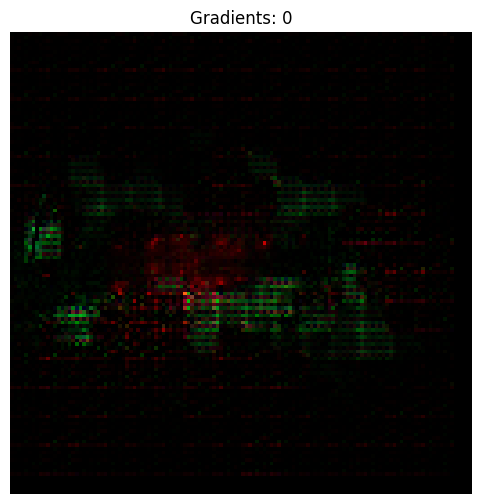

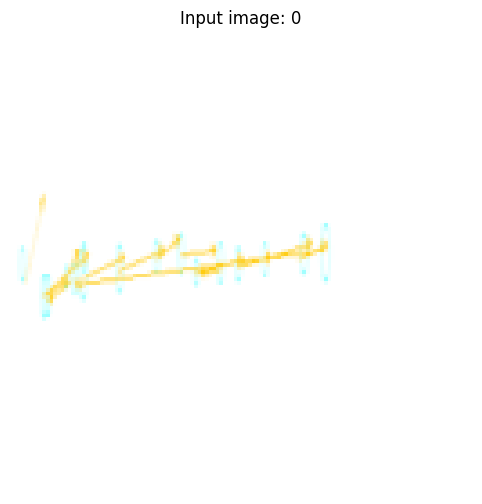

tensor([[ 61.5339, -60.7669]], grad_fn=<AddmmBackward0>)


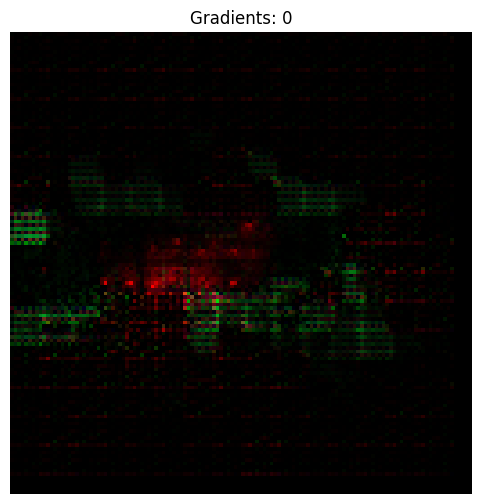

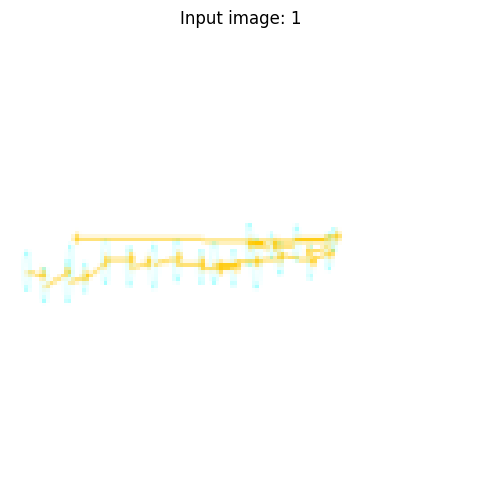

In [19]:
import matplotlib.pyplot as plt
import numpy as np

for imgs, labs in outer_cv.get_test_loader():
    i = 1
    lab = labs[i]
    input_image = imgs[i].clone().detach().requires_grad_(True)
    # Set the model to evaluation mode
    trainer.model.eval()
    trainer.model.cpu()
    
    # Forward pass to get the output
    output = trainer.model.forward(input_image.unsqueeze(0))  # Adding batch dimension
    _, pred = torch.max(output, 1)
    # Calculate gradients of the output with respect to the input image
    output.squeeze()[pred].backward()
    print(output)
    # Get the gradients from the input image
    gradients = input_image.grad.squeeze().numpy()
    gradients[gradients<0] = 0
    gradients = gradients / np.max(gradients)

    # Plot the gradients
    plt.figure(figsize=(8, 6))
    plt.imshow(np.transpose(gradients, (1, 2, 0)) )
    plt.title(f'Gradients: {pred.item()}')
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.imshow(np.transpose(input_image.detach().cpu().numpy(), (1, 2, 0)) )
    plt.title(f'Input image: {lab}')
    plt.axis('off')
    plt.show()
    
    

In [7]:
trainer.save_best_model()
print('testing on: ', outer_cv.get_test_participants())
trainer.test(outer_cv.get_test_loader())

No best model found
testing on:  ['10', '11', '13', '14']


AttributeError: 'Trainer' object has no attribute 'test'

In [33]:
test_model = BasicModel(in_size, out_size)
test_model.load_state_dict(torch.load(join(project_path, 'saved_models/scanpaths_base/model_epoch_16.pkl')))
test_pp = ['10', '11', '13', '14']

In [6]:
print(compute_f1score(test_model, dataset.get_loader(test_pp)))

0.884506041222459


In [8]:
print(compute_f1score(test_model, dataset.get_loader(test_pp)))

0.884506041222459


In [14]:
cfs = compute_confusion_matrices(test_model, dataset, test_pp)

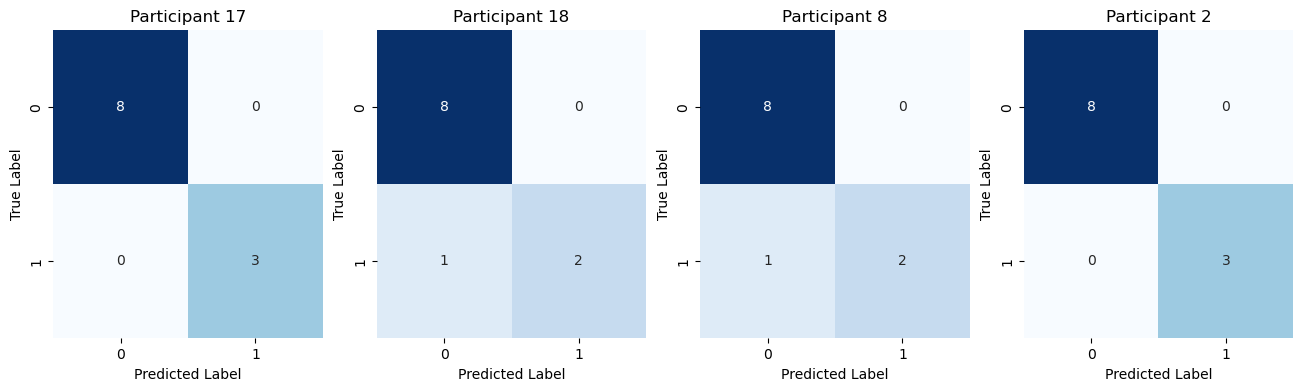

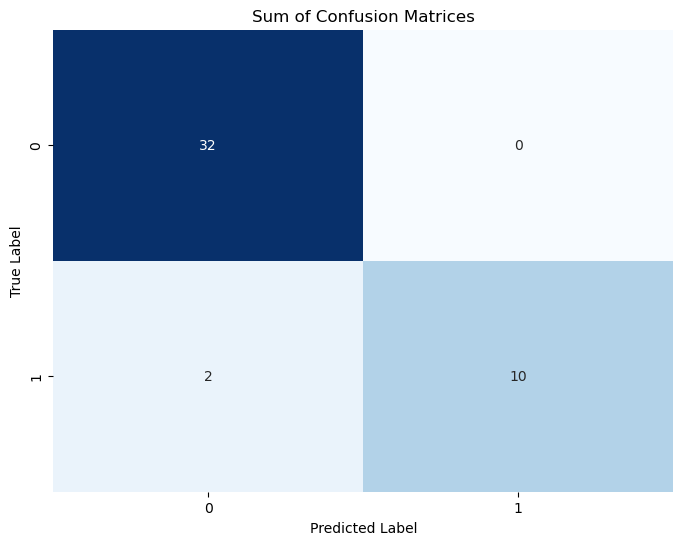

In [15]:
visualize_confusion_matrices(cfs)

In [4]:
trainer.logger = None
trainer.reset()
if model_type == 'base':
    model = BasicModel(in_size, out_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
trainer.set_optimizer(optimizer)
trainer.set_model(model)
inner_cv = MyKFoldCV(dataset, inner_kfolds, ignore=outer_cv.get_test_participants(), batch_size=batch_size)
print('testing on: ', outer_cv.get_test_participants())
print('training on: ', inner_cv.get_participants())
train_loader = inner_cv.get_train_loader()
test_loader = inner_cv.get_test_loader()
print('validating on: ', inner_cv.get_test_participants())
trainer.set_train_loader(train_loader)
trainer.set_val_loader(test_loader)

testing on:  ['10', '11', '13', '14']
training on:  ['15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7', '8', '9']
validating on:  ['15', '16', '17', '18']


In [13]:
train_loader = inner_cv.get_train_loader()
test_loader = inner_cv.get_test_loader()
trainer.set_train_loader(train_loader)
trainer.set_val_loader(test_loader)
for _ in range(20):
    trainer.run_epoch()

22.03 10:25:29 --- Epoch [46], Loss: 0.1236, Val acc: 100.00
22.03 10:25:30 --- Epoch [47], Loss: 0.0774, Val acc: 100.00
22.03 10:25:31 --- Epoch [48], Loss: 0.0857, Val acc: 100.00
22.03 10:25:32 --- Epoch [49], Loss: 0.0719, Val acc: 100.00
22.03 10:25:33 --- Epoch [50], Loss: 0.0689, Val acc: 100.00
22.03 10:25:34 --- Epoch [51], Loss: 0.0615, Val acc: 100.00
22.03 10:25:35 --- Epoch [52], Loss: 0.0489, Val acc: 100.00
22.03 10:25:37 --- Epoch [53], Loss: 0.0495, Val acc: 100.00
22.03 10:25:38 --- Epoch [54], Loss: 0.0385, Val acc: 100.00
22.03 10:25:39 --- Epoch [55], Loss: 0.0457, Val acc: 97.50
22.03 10:25:40 --- Epoch [56], Loss: 0.0446, Val acc: 100.00
22.03 10:25:41 --- Epoch [57], Loss: 0.0321, Val acc: 100.00
22.03 10:25:42 --- Epoch [58], Loss: 0.0609, Val acc: 100.00
22.03 10:25:43 --- Epoch [59], Loss: 0.0378, Val acc: 100.00
22.03 10:25:44 --- Epoch [60], Loss: 0.0331, Val acc: 100.00


KeyboardInterrupt: 

In [14]:
trainer.save_best_model()

Saving best model to   /home/gatemrou/uds/Eye_Tracking/saved_models/heatmaps_base_2024-03-22 10:18:34.918143/best_model.pkl
